In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import emcee
import torch
import sacc
import corner
import os
import pyccl as ccl
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc

import src.training as training
import src.models as models

from multiprocessing import Pool, cpu_count
from time import time
from importlib import reload
reload(training)
reload(models)

<module 'src.models' from '/home/b7009348/CosyMAML/src/models.py'>

[1.39018509 0.43816001 0.        ]


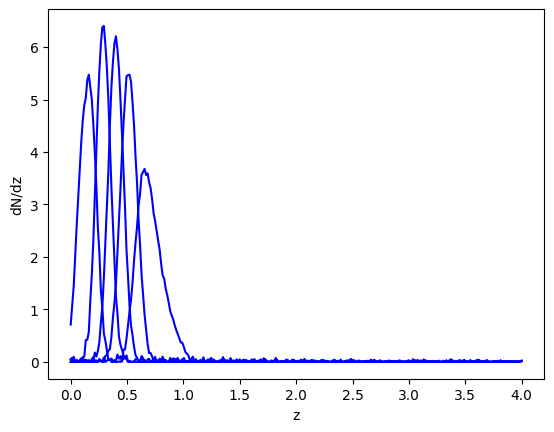

In [20]:
# Load a distribution from original training sample
filepath = 'data/1000tasks_5000samples_44seed.h5'
f = h5.File(filepath, 'r')

train_ind = 14
z_train = f['z'][train_ind]
bins_train = f['dndz'][train_ind]

test_ind = 42
z_test = f['z'][test_ind]
bins_test = f['dndz'][test_ind]
print(f['dndz_params'][test_ind])
for i in range(5):

    # plot
    plt.plot(z_train[i], bins_train[i], c='b', ls='-')
    #plt.plot(z_test[i], bins_test[i], c='r', ls='-')

# dummy artists for legend
plt.plot([], [], c='k', ls='-', label='Training')
plt.plot([], [], c='r', ls='-', label='Testing')
plt.xlabel('z')
plt.ylabel('dN/dz')
#plt.legend()

# Save test redshift data to a new file
new_f = h5.File('data/test_dndz.h5', 'w')
new_f.create_dataset('z', data=z_test)
new_f.create_dataset('dndz', data=bins_test)
new_f.close()

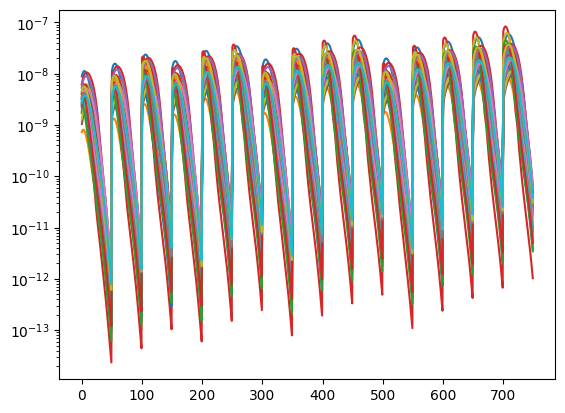

In [22]:
filepath = 'data/1000tasks_5000samples_44seed.h5'
f = h5.File(filepath, 'r')
c_ells = f['y_train'][14][80:120] 

# plot
for c_ell in c_ells:
    plt.plot(c_ell)
plt.yscale('log')

In [3]:
def compute_spectra(cosmo, dndz_ph_bins, z_ph, ells):
    
        n_bins = len(dndz_ph_bins)
        indices = np.tril_indices(n_bins)
        zipped_inds = list(zip(*indices))
    
        c_ells = np.empty((len(zipped_inds), len(ells)))
        for i, arg in enumerate(zipped_inds):
            j, k = arg
            tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z_ph[j], dndz_ph_bins[j]))
            tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z_ph[k], dndz_ph_bins[k]))
            c_ells[i,:] = ccl.angular_cl(cosmo, tracer1, tracer2, ells, l_limber='auto')

        return c_ells

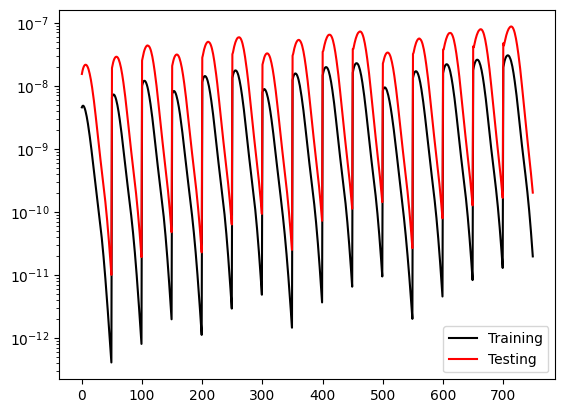

In [4]:
# compute spectra for different distributions
ells = np.geomspace(2, 5000, 50)
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, n_s=0.96, sigma8=0.83)
c_ells_train = compute_spectra(cosmo, bins_train, z_train, ells).flatten()
c_ells_test = compute_spectra(cosmo, bins_test, z_test, ells).flatten()

# plot
plt.plot(c_ells_train, c='k', ls='-', label='Training')
plt.plot(c_ells_test, c='r', ls='-', label='Testing')
plt.yscale('log')
plt.legend()

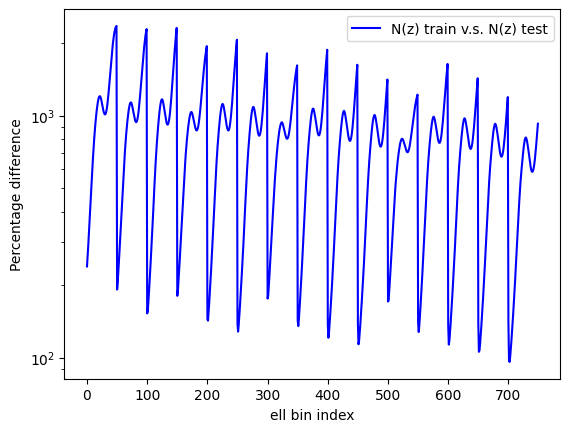

In [5]:
# percentage difference
diff = abs((c_ells_test - c_ells_train) / c_ells_train * 100)
plt.plot(diff, c='b', ls='-', label='N(z) train v.s. N(z) test')
plt.ylabel('Percentage difference')
plt.xlabel('ell bin index')
plt.yscale('log')
plt.legend()

In [6]:
X = f['X_train'][train_ind]
y = f['y_train'][train_ind]

# Take log of y
y_log = np.log(y)

# Split into test training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=14)

# Send data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to('cuda')
X_test = torch.tensor(X_test, dtype=torch.float32).to('cuda')
y_train = torch.tensor(y_train, dtype=torch.float32).to('cuda')
y_test = torch.tensor(y_test, dtype=torch.float32).to('cuda')

#Scale the data
ScalerX = training.TorchStandardScaler()
X_train = ScalerX.fit_transform(X_train)
X_test = ScalerX.transform(X_test)

ScalerY = training.TorchStandardScaler()
y_train = ScalerY.fit_transform(y_train)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

# Create a dataset and dataloader
class MCMCData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_data = MCMCData(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)

/home/b7009348/miniconda3/envs/cosymaml/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


X_train shape: torch.Size([4000, 10])
y_train shape: torch.Size([4000, 750])
X_test shape: torch.Size([1000, 10])
y_test shape: torch.Size([1000, 750])


In [ ]:
# Define the model
model = models.FastWeightCNN(
    input_size=10,
    latent_dim=(16,16),
    output_size=750,
    dropout_rate=0.2
)
model.to('cuda')

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Define the loss function
loss_fn = torch.nn.MSELoss()

n_epochs = 2048

train_losses = []
# set training mode 
model.train()
for epoch in range(n_epochs):
    X_batch, y_batch = next(iter(train_loader))

    optimizer.zero_grad()
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')

    train_losses.append(loss.item())

# Save model state as variable
original_model_state = model.state_dict()

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

ValueError: optimizer got an empty parameter list

Total predictions: torch.Size([4600, 750])


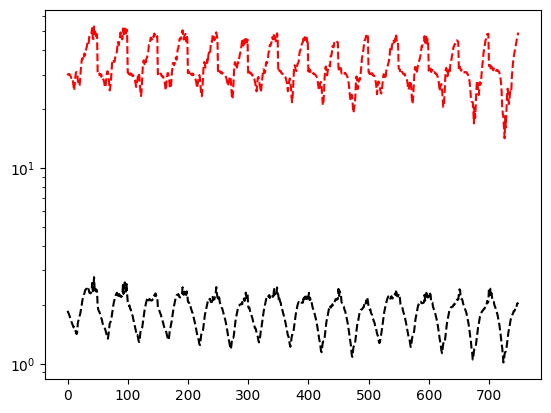

In [15]:
# test on the test set in batches
test_data = MCMCData(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=2048, shuffle=False)

# Construct empty tensor to store predictions
y_pred = torch.tensor([]).to('cuda')
test_losses = []
# Set model to evaluation mode
model.eval()
for X_batch, y_batch in test_loader:
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = model(X_batch)
        test_losses.append(loss_fn(y_pred_batch, y_batch).item())
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)

y_pred = torch.exp(ScalerY.inverse_transform(y_pred)).cpu().detach().numpy()
y_true = torch.exp(y_test).cpu().detach().numpy()

# Compute mean absolute percentage error along the test set
mape = np.mean(np.abs((y_true - y_pred) / y_true), axis=0) * 100
worst_ape = np.max(np.abs((y_true - y_pred) / y_true), axis=0) * 100
best_ape = np.min(np.abs((y_true - y_pred) / y_true), axis=0) * 100
plt.plot(mape, c='k', ls='--')
plt.plot(worst_ape, c='r', ls='--')
plt.yscale('log')

## Retrain on new distribution and compare to MAML

In [30]:
# Set training parameters
n_samples = 100
n_epochs = 128

In [31]:
X = f['X_train'][test_ind]
y = f['y_train'][test_ind]

# Take log of y
y_log = np.log(y)

# Split into test training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, train_size=n_samples, random_state=14
)

# Send data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to('cuda')
X_test = torch.tensor(X_test, dtype=torch.float32).to('cuda')
y_train = torch.tensor(y_train, dtype=torch.float32).to('cuda')
y_test = torch.tensor(y_test, dtype=torch.float32).to('cuda')

#Scale the data
ScalerX = training.TorchStandardScaler()
X_train = ScalerX.fit_transform(X_train)
X_test = ScalerX.transform(X_test)

ScalerY = training.TorchStandardScaler()
y_train = ScalerY.fit_transform(y_train)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

# Create a dataset and dataloader
class MCMCData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_data = MCMCData(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)

X_train shape: torch.Size([100, 10])
y_train shape: torch.Size([100, 750])
X_test shape: torch.Size([4900, 10])
y_test shape: torch.Size([4900, 750])


Epoch 0 Loss: 0.08284257352352142
Epoch 10 Loss: 0.019062405452132225
Epoch 20 Loss: 0.006254265084862709
Epoch 30 Loss: 0.003989919554442167
Epoch 40 Loss: 0.002432383829727769
Epoch 50 Loss: 0.002694371622055769
Epoch 60 Loss: 0.002224088180810213
Epoch 70 Loss: 0.002086350927129388
Epoch 80 Loss: 0.0016647342126816511
Epoch 90 Loss: 0.002644309774041176
Epoch 100 Loss: 0.002291854238137603
Epoch 110 Loss: 0.0015335232019424438
Epoch 120 Loss: 0.002124654594808817


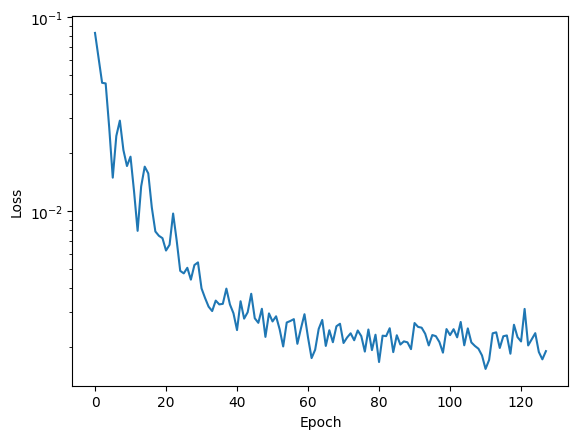

In [32]:
# load the model state
model.load_state_dict(original_model_state)

train_losses = []
# set training mode
model.train()
for epoch in range(n_epochs):
    X_batch, y_batch = next(iter(train_loader))

    optimizer.zero_grad()
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')

    train_losses.append(loss.item())

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

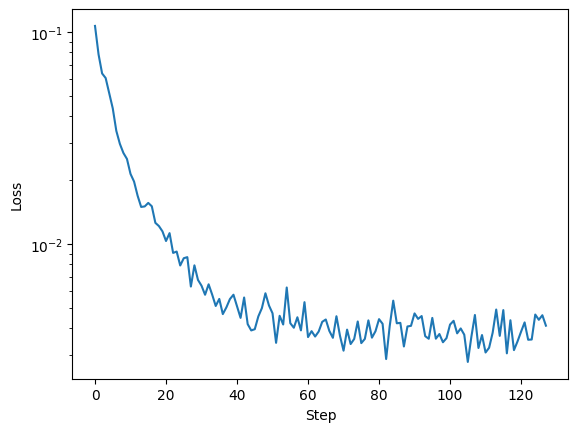

In [33]:
maml_model = models.FastWeightCNN(
    input_size=10,
    latent_dim=(16,16),
    output_size=750,
    dropout_rate=0.2
)

# Create a new MetaLearner instance
metalearner = training.MetaLearner(
    model=maml_model,
    outer_lr=0.01,
    inner_lr=0.001,
    loss_fn=torch.nn.MSELoss,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    seed=14,
    device='cuda'
)

# Load metaleraner weights
metalearner.model.load_state_dict(
    torch.load(
        '{}batch_{}epoch_metalearner_weights.pt'.format(20, 500)
    )
)

# Perform finetuning
task_weights, losses = metalearner.finetune(X_train, y_train, adapt_steps=n_epochs)

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')

Total predictions: torch.Size([4900, 750])
MAML
Mean APE: 4.0839024
Worst APE: 66.00398
Total predictions: torch.Size([4900, 750])
Standard
Mean APE: 5.250301
Worst APE: 129.80649


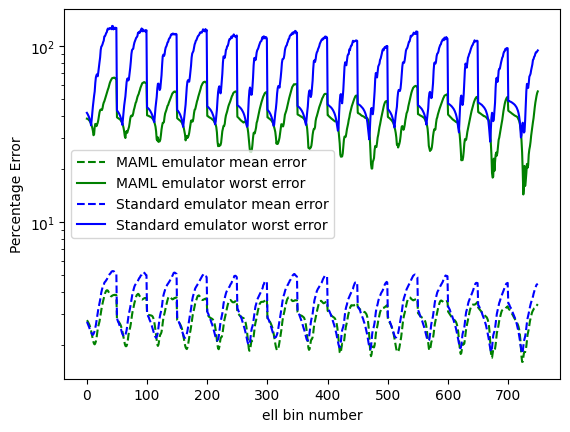

In [34]:
############# MAML TRAINING #############

# test on the test set in batches
test_data = MCMCData(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=2048, shuffle=False)

# Construct empty tensor to store 
metalearner.model.eval()
y_pred = torch.tensor([]).to('cuda')
for X_batch, y_batch in test_loader:
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = metalearner.model(X_batch, params=task_weights)
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)
# Inverse transform the data
y_pred = ScalerY.inverse_transform(y_pred)

y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Exponentiate the data
y_pred_np = np.exp(y_pred_np)
y_test_np = np.exp(y_test_np)

# Compute mean absolute percentage error along the test set
mape = np.mean(np.abs((y_test_np - y_pred_np) / y_test_np), axis=0) * 100
worst_ape = np.max(np.abs((y_test_np - y_pred_np) / y_test_np), axis=0) * 100
best_ape = np.min(np.abs((y_test_np - y_pred_np) / y_test_np), axis=0) * 100
plt.plot(mape, c='g', ls='--', label='MAML emulator mean error')
plt.plot(worst_ape, c='g', ls='-', label='MAML emulator worst error')
plt.yscale('log')

print('MAML')
print('Mean APE:', mape.max())
print('Worst APE:', worst_ape.max())

############# STANDARD TRAINING #############

# Construct empty tensor to store predictions
model.eval()
y_pred = torch.tensor([]).to('cuda')
for X_batch, y_batch in test_loader:
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = model(X_batch)
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)
# Inverse transform the data
y_pred = ScalerY.inverse_transform(y_pred)

y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Exponentiate the data
y_pred_np = np.exp(y_pred_np)
y_test_np = np.exp(y_test_np)

# Compute mean absolute percentage error along the test set
mape = np.mean(np.abs((y_test_np - y_pred_np) / y_test_np), axis=0) * 100
worst_ape = np.max(np.abs((y_test_np - y_pred_np) / y_test_np), axis=0) * 100
best_ape = np.min(np.abs((y_test_np - y_pred_np) / y_test_np), axis=0) * 100
plt.plot(mape, c='b', ls='--', label='Standard emulator mean error')
plt.plot(worst_ape, c='b', ls='-', label='Standard emulator worst error')
plt.ylabel('Percentage Error')
plt.xlabel('ell bin number')
plt.legend()

print('Standard')
print('Mean APE:', mape.max())
print('Worst APE:', worst_ape.max())